Deep Learning
-------------

*Assignment 1*
The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing  
later. This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset,  
while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [17]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [18]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


**Problem 1**

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a  
different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.
----------------------------------------------------------------------------------------------------------------------------------------------------

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll  
load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of  
 manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and  
standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [19]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

In [20]:
#Problem 1: Sanities 
from IPython.display import Image

print (len(test_datasets))
print (len(train_datasets))
A = pickle.load( open(train_datasets[0], "rb") )
print( type(A) )
Image(filename="notMNIST_small/A/MDEtMDEtMDAudHRm.png")

10
10


<type 'numpy.ndarray'>


<IPython.core.display.Image object>

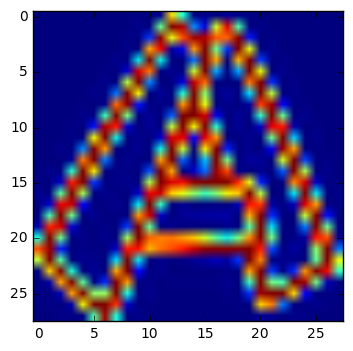

(28, 28)


(52909, 28, 28)


In [7]:
# Plot from array
print(A.shape)
A3 = A[2]
plt.imshow(A3)
print(A3.shape)

**Problem 3**
Another check: we expect the data to be balanced across classes. Verify that.

In [8]:
letters=[]
for letter in train_datasets:
    letters.append(pickle.load( open(letter, "rb") ))

In [9]:
for l in letters:
    print (l.shape)
np.std([
52909,
52911,
52912,
52911,
52912,
52912,
52912,
52912,
52912,
52911])

0.9165151389911681

(52909, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52911, 28, 28)


-----------------------------------------------------------------------------

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune  
train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [21]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [22]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

**Problem 4**

Convince yourself that the data is still good after shuffling!
-------------------------------------------------------------

Finally, let's save the data for later reuse:

In [23]:
pickle_file = './pickled/notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [3]:
					###############################################
					#Loading train, valid, and test, dataset split#
					###############################################

pickle_file = './pickled/notMNIST.pickle'
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

try:
    f = open(pickle_file, 'rb')
    pcklData = pickle.load(f)
except Exception as e:
  print('Unable to load data from', pickle_file, ':', e)
  raise


Compressed pickle size: 690800441


In [4]:
# Loading to original variable names
train_dataset =   pcklData['train_dataset']
train_labels  =   pcklData['train_labels' ]
valid_dataset =   pcklData['valid_dataset']
valid_labels  =   pcklData['valid_labels' ]
test_dataset  =   pcklData['test_dataset' ]
test_labels   =   pcklData['test_labels'  ]


**Problem 5**

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test  
set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but  
are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and  
test samples.

Optional questions: 

* What about near duplicates between datasets? (images that are almost identical)
* Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.


In [2]:
######################
# unflatten function

def unflatten(x):
    n = int(np.sqrt(len(x)))
    xX = np.array([ [0.0 for i in xrange(n)] for j in xrange(n)] )
    for i in xrange(n):
        for j in xrange(n):
            xX[i,j] = x[i*n + j]
    return xX

######################
# Pickling function

def Ipckl(file_name, opr,Data=None):
    try:
	f = open(file_name, opr)
	if opr == 'wb':
	    pickle.dump(Data, f, pickle.HIGHEST_PROTOCOL)
	elif opr == 'rb':
	    return pickle.load(f)
	f.close()
    except Exception as e:
      print('Unable to '+ opr[0] + ' data. file:', file_name, ':', e)
      raise
  


In [5]:
####################
#Overlap exploration
####################
from time import time

In [28]:
# Flatten two dimensional image arrays into n*n dimension vectors

X_train = np.array([image.flatten() for image in train_dataset])
X_valid = np.array([image.flatten() for image in valid_dataset])
X_test  = np.array([image.flatten() for image in test_dataset])

In [29]:
X_train.shape

(200000, 784)

In [33]:
# Reduce dimension size to n_components
from sklearn.decomposition import RandomizedPCA
n_components = 120

print ("Extracting the top {} eigenvectors from {} letters".format(n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print ("done in {}".format(time() - t0) )

# Applying pca projection to data
X_train_pca = pca.transform(X_train, n_components)
X_valid_pca = pca.transform(X_valid, n_components)
X_test_pca  = pca.transform(X_test, n_components)

print( X_train.shape, X_train_pca.shape)

#######Saving PCA transformation data##########
pca_data = {
 'X_train_pca' :  X_train_pca,
 'X_valid_pca' :  X_valid_pca,
 'X_test_pca'  :  X_test_pca ,
 }
 
Ipckl('./pickled/pca_data.pickle', 'wb', pca_data)


Extracting the top 120 eigenvectors from 200000 letters


done in 8.3912730217


(200000, 784) (200000, 120)


In [11]:
H_pca = unflatten(X_train_pca[0])
plt.imshow(H_pca)

In [6]:
############Load PCA transformed data#############
pca_data = Ipckl('./pickled/pca_data.pickle', 'rb')

X_train_pca = pca_data['X_train_pca']
X_valid_pca = pca_data['X_valid_pca']  
X_test_pca  = pca_data['X_test_pca' ]  

In [7]:
print( X_train_pca.shape, X_valid_pca.shape, X_test_pca.shape )

(200000, 120) (10000, 120) (10000, 120)


In [0]:
########################
#Clustering exploration#
########################

In [70]:
from sklearn.cluster import DBSCAN

dbscn = DBSCAN(eps=0.0005, min_samples=2)
all_data = np.concatenate( (X_train_pca , X_valid_pca, X_test_pca), axis=0 )

############################
start = time()
dblabels = dbscn.fit_predict( all_data )
cores = dbscn.components_
core_labels = dbscn.core_sample_indices_
stop  = time() - start
############################

print ('done in {} s'.format(stop))

#######Saving cluster and core labels##########
dbscan_labels = {
 'dblabels'    :  dblabels,
 'core_labels' : core_labels,
 'cores':  cores,
 }
 
Ipckl('./pickled/dbscan_labels.pickle', 'wb', dbscan_labels)


done in 24.7015779018 s


In [8]:
#######Loading cluster and core labels##########
dbscan_labels = Ipckl('./pickled/dbscan_labels.pickle', 'rb')

dblabels    = dbscan_labels['dblabels']
core_labels = dbscan_labels['core_labels']
cores       = dbscan_labels['cores'   ]


My attempted approach is to identify repeated data samples by finding really 'tight' clusters using DBSCAN (i.e. I set eps=0.0005) the reasoning
being that the limiting case of closeness is equality. 

In [10]:
#########Removing duplicates (or approximate duplicates)###########
print( "DBSCAN found: {} types of 'tight' groups".format( max(dblabels) - min(dblabels)) )

###
all_data = np.concatenate( (X_train_pca , X_valid_pca, X_test_pca), axis=0 )
all_labels = np.concatenate( (train_labels, valid_labels, test_labels), axis=0 )
unique_data = []
u_targets = []
cluster_no = np.zeros( max(dblabels+1) )  # The class labels are sequential from -1 to the largest number in dblades

for i, x in enumerate(all_data):
  
    if dblabels[i] == -1:                 # clusters of one (already unique)
       unique_data.append(x)
       u_targets.append(all_labels[i])
       
    elif cluster_no[dblabels[i]] == 0:    # grab one representative of each cluster of more than one member
       cluster_no[dblabels[i]] +=1
       unique_data.append(x)
       u_targets.append(all_labels[i])
       
unique_data = np.array(unique_data)
u_targets = np.array(u_targets)

print(all_data.shape, unique_data.shape)

(220000, 120) (204961, 120)


DBSCAN found: 10759 types of 'tight' groups


In [128]:
##################################################################
#Reconstructing train, valid and test sets after duplicate removal
from sklearn.cross_validation import train_test_split

uX_train_pca, Xtemp, uy_train_pca, ytemp = train_test_split(unique_data, u_targets, test_size=0.10, random_state=0)
uX_valid_pca, uX_test_pca, uy_valid_pca,  uy_test_pca = train_test_split(Xtemp, ytemp, test_size=0.50, random_state=0)

######Saving data after duplicate removal##########
upca_data = {
 'uX_train_pca' :  uX_train_pca,
 'uX_valid_pca' :  uX_valid_pca,
 'uX_test_pca'  :  uX_test_pca ,
 'uy_train_pca' :  uy_train_pca,
 'uy_valid_pca' :  uy_valid_pca,
 'uy_test_pca'  :  uy_test_pca ,
 }
 
Ipckl('./pickled/upca_data.pickle', 'wb', upca_data)


In [12]:
#######Loading data after duplicate removal##########
upca_data = Ipckl('./pickled/upca_data.pickle', 'rb')

uX_train_pca = upca_data['uX_train_pca']
uX_valid_pca = upca_data['uX_valid_pca']  
uX_test_pca  = upca_data['uX_test_pca' ]  
uy_train_pca = upca_data['uy_train_pca']  
uy_valid_pca = upca_data['uy_valid_pca']  
uy_test_pca  = upca_data['uy_test_pca' ]  


In [20]:
							#########################
							# Linear-model Training #
							#########################							

In [27]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
k = 50

start = time()#####################
logr.fit(X_train_pca, train_labels)
stop  = time()#####################


print(logr.score(X_valid_pca, valid_labels), stop - start)

0.8275 35.9019989967


In [29]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
k = 50

start = time()#####################
logr.fit(uX_train_pca, uy_train_pca)
stop  = time()#####################


print(logr.score(uX_valid_pca, uy_valid_pca), stop - start)

0.823575331772 32.9561469555


**Problem 6**

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and  
that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from  
sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!
